In [45]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

%matplotlib inline 

# 1 Exploratory data analysis

In [46]:
with open('logins.json','r') as json_file:
    logins_data = json.load(json_file)

In [47]:
logins_df = pd.DataFrame(logins_data)
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [48]:
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

Aggregate these login counts based on 15 minute time intervals

In [49]:
logins_df['case'] = 1
logins_15_df = logins_df.groupby(pd.Grouper(freq='15T',key='login_time')).agg(count=('case', 'sum'))

In [50]:
logins_15_df

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


## 1.1 visulaize the time series

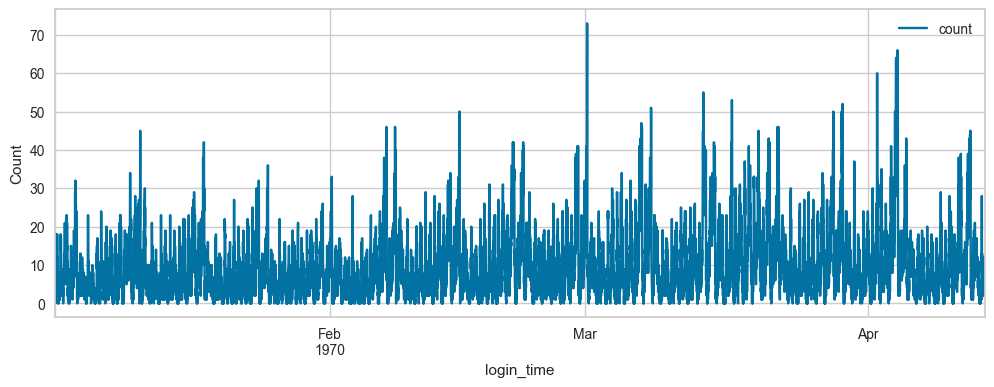

In [51]:
logins_15_df.plot(figsize = (12,4), ylabel = 'Count');

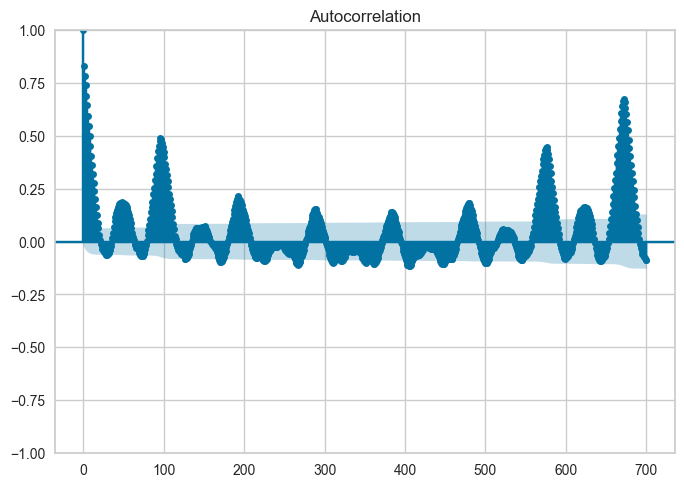

In [52]:
plot_acf(logins_15_df['count'], lags = 700, alpha = 0.05, fft = True);

In [53]:
print('Autocorrelation lagged by day:', logins_15_df['count'].autocorr(lag=96))
print('Autocorrelation lagged by week:',logins_15_df['count'].autocorr(lag=96*7))


Autocorrelation lagged by day: 0.49284766069880676
Autocorrelation lagged by week: 0.7082965796340609


autocorrelation with a lag of 96 is high and positive, suggesting the daily period

Use seasonal_decompose function to visualize the data：

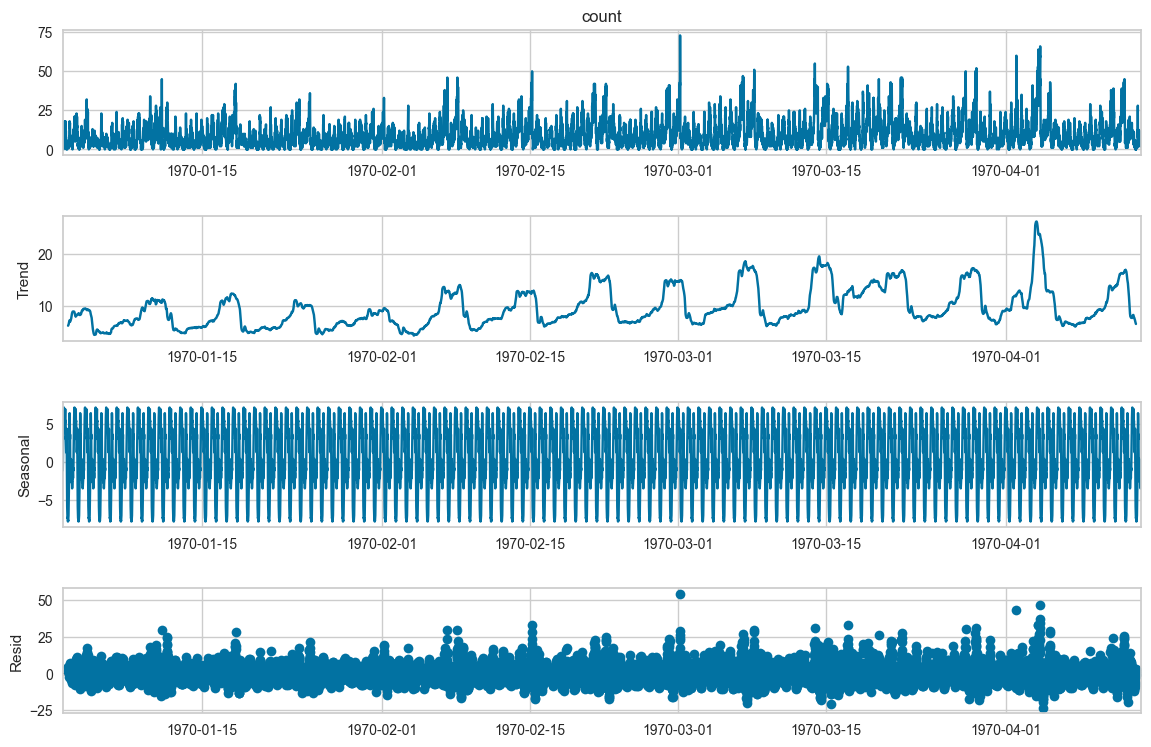

In [54]:
decomposition = seasonal_decompose(logins_15_df['count'], period = 96)
# Plot the original data, the trend, the seasonality, and the residuals 
fig = decomposition.plot()
fig.set_size_inches(12, 8)

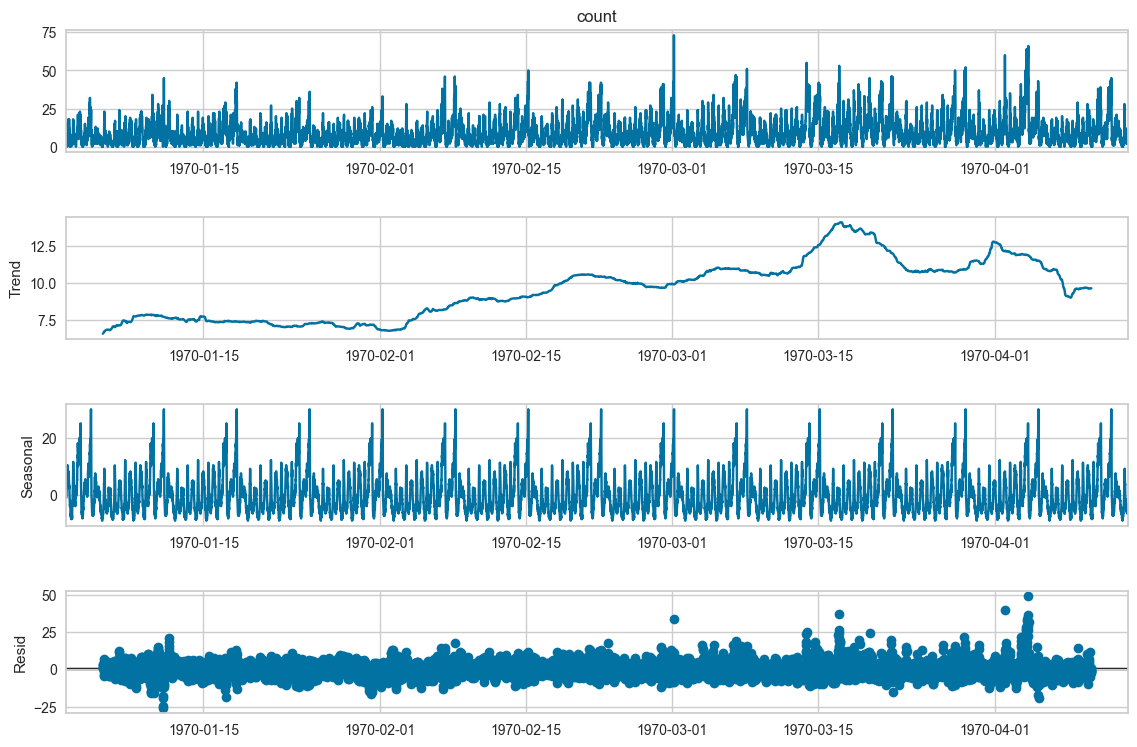

In [55]:
decomposition = seasonal_decompose(logins_15_df['count'], period = 96*7)
# Plot the original data, the trend, the seasonality, and the residuals 
fig = decomposition.plot()
fig.set_size_inches(12, 8)

## 1.2 Check whether the time series is stationary

### 1.2.1 ADF

Using augmented Dickey-Fuller test to test whether the data is a random walk.

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

In [56]:
results = adfuller(logins_15_df['count'])
print("p-value is ",results[1])

p-value is  2.7323966542228277e-18


In [57]:
results = adfuller(logins_15_df['count'].diff(96).dropna())
print("p-value is ",results[1])

p-value is  6.596597267624974e-20


In [58]:
results = adfuller(logins_15_df['count'].diff(96*7).dropna())
print("p-value is ",results[1])

p-value is  9.814262392180243e-27


Therefore, P-value of original time series is much less than 0.05, so we reject the null hypothesis of a random walk. After transformation (shifting with 96 or 96*7), the series is more stationary than the original.

### 1.2.2 KPSS

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite to that of the ADF test. Its null hypothesis is the process is trend stationary.

In [59]:
results = kpss(logins_15_df['count'])
print("p-value is ",results[1])

p-value is  0.01


Because p-value is relatively small, we reject the null hypothesis.  The original series is non-stationary as per the KPSS test.

In [60]:
results = kpss(logins_15_df['count'].diff(96).dropna())
print("p-value is ",results[1])

p-value is  0.1


In [61]:
results = kpss(logins_15_df['count'].diff(96*7).dropna())
print("p-value is ",results[1])

p-value is  0.0683891921129126


The series with a shift of 96 is stationary as per the KPSS test.

Overall, the time series is more stationary after shifting by day or week.

## 1.3 Features of the demand

In [63]:
logins_15_df['day'] = logins_15_df.index.weekday
logins_15_df['weekend'] = logins_15_df['day'].replace([0, 1, 2, 3,4,5,6], [0, 0,0, 0,0, 1,1]) 

logins_15_df

,count,day,weekend
login_time,,,
1970-01-01 20:00:00,2,3,0
1970-01-01 20:15:00,6,3,0
1970-01-01 20:30:00,9,3,0
1970-01-01 20:45:00,7,3,0
1970-01-01 21:00:00,1,3,0
...,...,...,...
1970-04-13 17:45:00,5,0,0
1970-04-13 18:00:00,5,0,0
1970-04-13 18:15:00,2,0,0


In [86]:
# Daily cycles
logins_15_df['dates'] = logins_15_df.reset_index()['login_time'].dt.date.values
logins_15_df['time'] = logins_15_df.reset_index()['login_time'].dt.time.values
logins_15_df['dates'] = pd.to_datetime(logins_15_df['dates'])


In [88]:
logins_15_df

,count,day,weekend,dates,time
login_time,,,,,
1970-01-01 20:00:00,2,3,0,1970-01-01,20:00:00
1970-01-01 20:15:00,6,3,0,1970-01-01,20:15:00
1970-01-01 20:30:00,9,3,0,1970-01-01,20:30:00
1970-01-01 20:45:00,7,3,0,1970-01-01,20:45:00
1970-01-01 21:00:00,1,3,0,1970-01-01,21:00:00
...,...,...,...,...,...
1970-04-13 17:45:00,5,0,0,1970-04-13,17:45:00
1970-04-13 18:00:00,5,0,0,1970-04-13,18:00:00
1970-04-13 18:15:00,2,0,0,1970-04-13,18:15:00


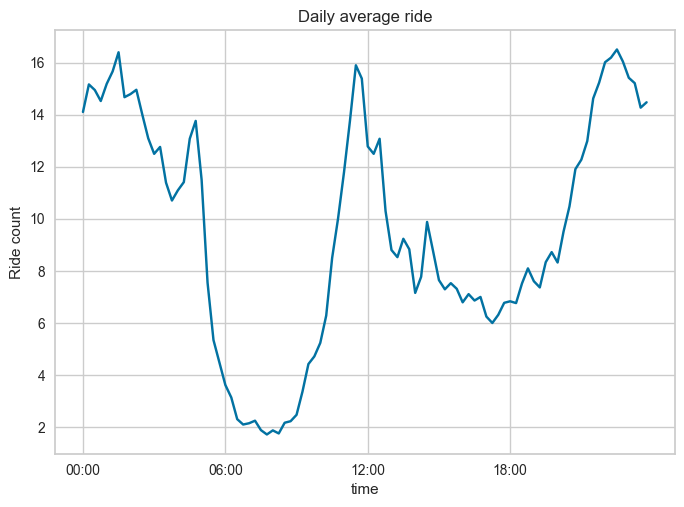

In [98]:
logins_daily_df = logins_15_df.groupby(['time'])['count'].mean()
logins_daily_df.plot(xticks = ['00:00','06:00','12:00','18:00'],title = 'Daily average ride',ylabel = 'Ride count');

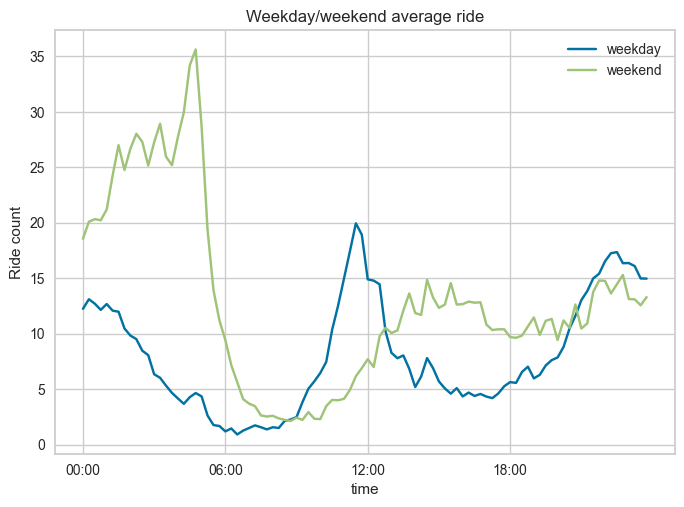

In [97]:
logins_daytype_df = logins_15_df.pivot_table(values='count', index='time', columns='weekend', aggfunc='mean')
logins_daytype_df.columns = ['weekday','weekend']
logins_daytype_df.plot(xticks = ['00:00','06:00','12:00','18:00'], title = 'Weekday/weekend average ride',ylabel = 'Ride count');

* On weekdays, the ride peaks occurs around 11 am and 10 pm, possibly related to people's working routine. Daily feature shows there are two periods with a shift mean.

* On weekend, the ride count surge at the early morning due to night life; the average ride counts are higher than weekday in the afternoon.

# 2 Experiment and metrics design

## 2.1 What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

A: The activities increases during the day in Ultimate Gotham and in the night in  Ultimate Metropolis  because activities or interaction between two cities increase.

## 2.2 Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

### a) how you will implement the experiment?

A: Reimburse all toll costs for a month and collect all the activities in the two cities. Compare the activities distribution in the day and night before and after the reimbursements. Use freqntist inference to deduce whether the daily activities in Ultimate Gotham and nightly activities in Ultimate Metropolis increase.

### b) what statistical test(s) you will conduct to verify the significance of the observation?

A; Calculate the margin of error to compre the average daily and night activities before and after the experiment.

Calculate the p-value of the hypothesis test that the mean of distribution with or without reimbursement are equal.


### c)  how you would interpret the results and provide recommendations to the city operations team along with any caveats.

A: If the experiment results support that the reimbursment increases the daytime activities in Gotham or the nightime activities in Metropolitans. I would suggest the strategy and collect more data (at least two quarters) to update the results, in case that some specific months (e.g., holiday season) create outliers.

# 3 Predictive modeling

In [2]:
with open('ultimate_data_challenge.json','r') as json_file:
    ultimate_data = json.load(json_file)

In [3]:
ultimate_df = pd.DataFrame(ultimate_data)
ultimate_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [4]:
ultimate_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [5]:
ultimate_df[["signup_date", "last_trip_date"]] = ultimate_df[["signup_date", "last_trip_date"]].apply(pd.to_datetime)

In [6]:
ultimate_df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [7]:
ultimate_df.nunique()

city                         3
trips_in_first_30_days      59
signup_date                 31
avg_rating_of_driver        37
avg_surge                  115
last_trip_date             182
phone                        2
surge_pct                  367
ultimate_black_user          2
weekday_pct                666
avg_dist                  2908
avg_rating_by_driver        27
dtype: int64

In [8]:
ultimate_df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [9]:
ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(ultimate_df['avg_rating_of_driver'].median())
ultimate_df['avg_rating_by_driver'] = ultimate_df['avg_rating_by_driver'].fillna(ultimate_df['avg_rating_by_driver'].median())
ultimate_df.fillna('ffill', inplace =  True)

In [10]:
ultimate_df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [11]:
ultimate_df['retained_user'] = False

In [12]:
ultimate_df.loc[ultimate_df['trips_in_first_30_days'] >= 1,'retained_user'] = True

## 3.1 What fraction of the observed users were retained?

In [13]:
print('The ratio of retained users in the samples is ', ultimate_df['retained_user'].mean())

The ratio of retained users in the samples is  0.6922


## 3.2 A predictive model to predict whether a user to be active in the 6th month

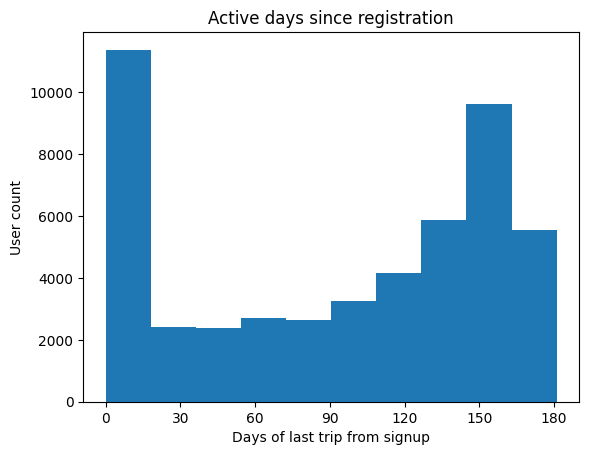

In [14]:
(ultimate_df['last_trip_date'] - ultimate_df['signup_date']).dt.days.plot(
    kind = 'hist',title = 'Active days since registration')
_ = plt.xlabel('Days of last trip from signup')
_ = plt.ylabel('User count')
_ = plt.xticks(np.arange(0,181, 30));


In [15]:
ultimate_df['active_aft_6M'] = False
ultimate_df.loc[(ultimate_df['last_trip_date'] - ultimate_df['signup_date']).dt.days >= 150,'active_aft_6M'] = True

In [16]:
ultimate_df['active_aft_6M'].mean()

0.25428

In [17]:
ultimate_df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained_user                       bool
active_aft_6M                       bool
dtype: object

In [18]:
df = ultimate_df.drop(columns = ["signup_date", "last_trip_date"])

In [24]:
df['retained_user'] = df['retained_user'] .astype(int)
df['ultimate_black_user'] = df['ultimate_black_user'] .astype(int)
df['active_aft_6M'] = df['active_aft_6M'] .astype(int)

In [19]:
from pycaret.classification import *

In [26]:
exp_name = setup(data = df,  
                 target = 'active_aft_6M',
                 session_id = 22,
                 data_split_stratify = True,
                 categorical_features=['city','phone','retained_user','ultimate_black_user'],
                )

,Description,Value
0,Session id,22
1,Target,active_aft_6M
2,Target type,Binary
3,Original data shape,"(50000, 12)"
4,Transformed data shape,"(50000, 16)"
5,Transformed train set shape,"(34999, 16)"
6,Transformed test set shape,"(15001, 16)"
7,Ordinal features,2
8,Numeric features,9
9,Categorical features,4


In [33]:
top3 = compare_models(n_select = 3, sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7979,0.8270,0.4546,0.6459,0.5335,0.4095,0.4199,4.5710
nb,Naive Bayes,0.7271,0.7413,0.6057,0.4716,0.5302,0.3421,0.3475,1.5520
gbc,Gradient Boosting Classifier,0.7954,0.8237,0.4263,0.6488,0.5145,0.3918,0.4057,7.6320
ada,Ada Boost Classifier,0.7934,0.8171,0.4248,0.6415,0.5111,0.3869,0.4001,4.1270
rf,Random Forest Classifier,0.7678,0.7842,0.4581,0.5524,0.5007,0.3512,0.3539,7.6400
qda,Quadratic Discriminant Analysis,0.6474,0.7117,0.6597,0.3933,0.4886,0.2488,0.2703,1.9510
et,Extra Trees Classifier,0.7573,0.7685,0.4561,0.5264,0.4886,0.3306,0.3322,13.3690
knn,K Neighbors Classifier,0.7596,0.7454,0.4133,0.5355,0.4664,0.3146,0.3190,2.5860
dt,Decision Tree Classifier,0.7196,0.6335,0.4573,0.4495,0.4533,0.2648,0.2648,1.7140
lda,Linear Discriminant Analysis,0.7614,0.7369,0.2135,0.5842,0.3125,0.2044,0.2425,3.5340


In [34]:
tuned_top3 = [tune_model(i, optimize = 'F1') for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7877,0.8230,0.4348,0.6172,0.5102,0.3799,0.3894
1,0.8029,0.8323,0.4719,0.6562,0.5490,0.4272,0.4367
2,0.7960,0.8268,0.4551,0.6388,0.5315,0.4058,0.4153
3,0.8000,0.8236,0.4652,0.6489,0.5419,0.4184,0.4279
4,0.7889,0.8209,0.4404,0.6193,0.5148,0.3847,0.3938
5,0.8077,0.8328,0.4798,0.6703,0.5593,0.4406,0.4507
6,0.7983,0.8352,0.4449,0.6513,0.5287,0.4061,0.4181
7,0.8014,0.8317,0.4674,0.6531,0.5449,0.4223,0.4320
8,0.8017,0.8306,0.4708,0.6526,0.5470,0.4243,0.4336


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7234,0.7439,0.6067,0.4663,0.5273,0.3366,0.3424
1,0.7263,0.7336,0.5921,0.4697,0.5239,0.3354,0.3398
2,0.7283,0.7387,0.6112,0.4735,0.5336,0.3462,0.3519
3,0.7137,0.7252,0.5787,0.4510,0.5069,0.3095,0.3143
4,0.7389,0.7505,0.5865,0.4888,0.5332,0.3540,0.3568
5,0.7283,0.7469,0.6247,0.4740,0.5390,0.3515,0.3582
6,0.7326,0.7491,0.6045,0.4795,0.5348,0.3506,0.3553
7,0.7331,0.7352,0.5899,0.4799,0.5292,0.3458,0.3494
8,0.7269,0.7460,0.6135,0.4715,0.5332,0.3448,0.3508


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7863,0.8196,0.4427,0.6099,0.5130,0.3805,0.3885
1,0.7989,0.8247,0.4730,0.6418,0.5446,0.4193,0.4274
2,0.7880,0.8191,0.4573,0.6111,0.5231,0.3904,0.3972
3,0.7983,0.8155,0.4640,0.6433,0.5392,0.4143,0.4234
4,0.7894,0.8162,0.4393,0.6216,0.5148,0.3854,0.3948
5,0.8023,0.8260,0.4663,0.6566,0.5453,0.4236,0.4337
6,0.7957,0.8274,0.4528,0.6387,0.5299,0.4042,0.4140
7,0.7960,0.8264,0.4629,0.6358,0.5358,0.4092,0.4176
8,0.7974,0.8235,0.4551,0.6439,0.5332,0.4087,0.4188


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [36]:
best_F1_model = automl(optimize = 'F1')

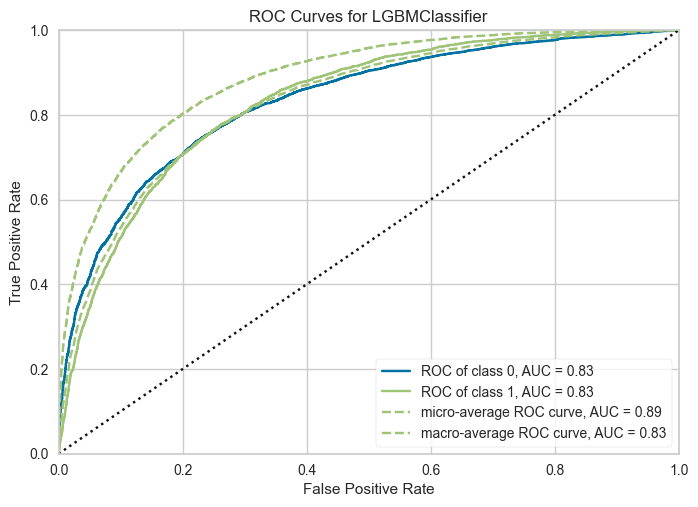

In [37]:
plot_model(best_F1_model, plot = 'auc')

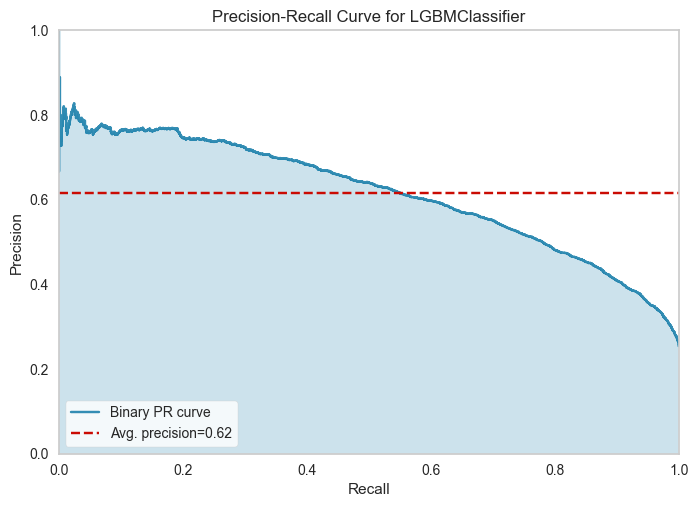

In [44]:
plot_model(best_F1_model, plot = 'pr')

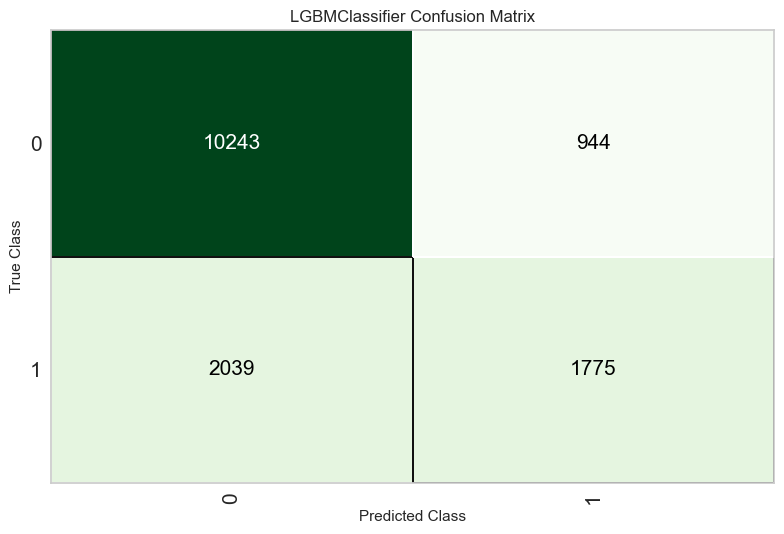

In [38]:
plot_model(best_F1_model, plot = 'confusion_matrix')

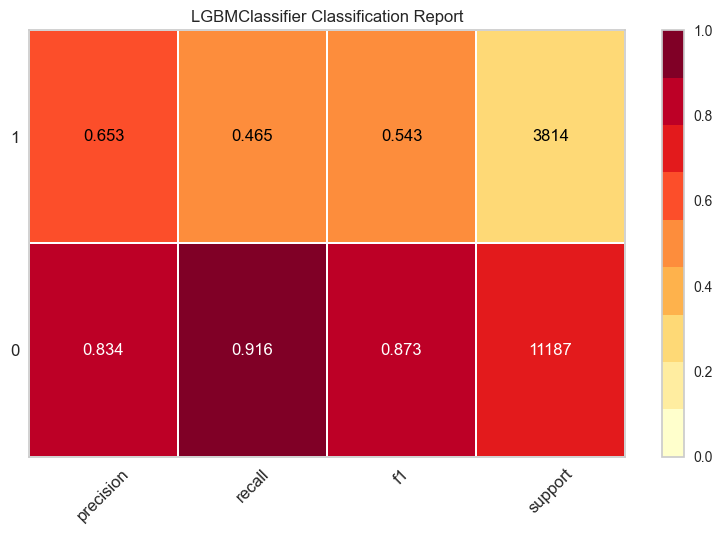

In [39]:
plot_model(best_F1_model, plot = 'class_report')

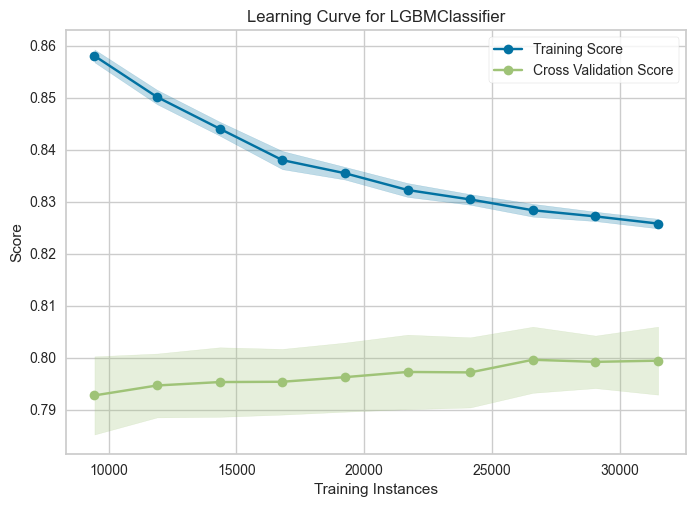

In [40]:
plot_model(best_F1_model, plot = 'learning')

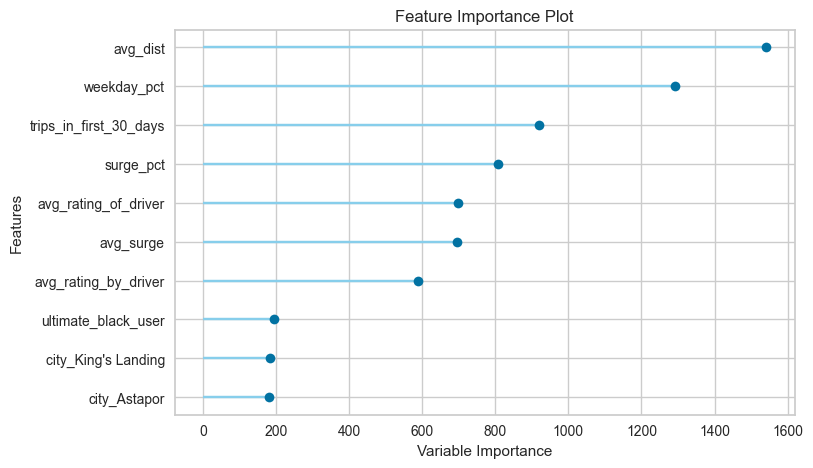

In [43]:
plot_model(best_F1_model, plot = 'feature')

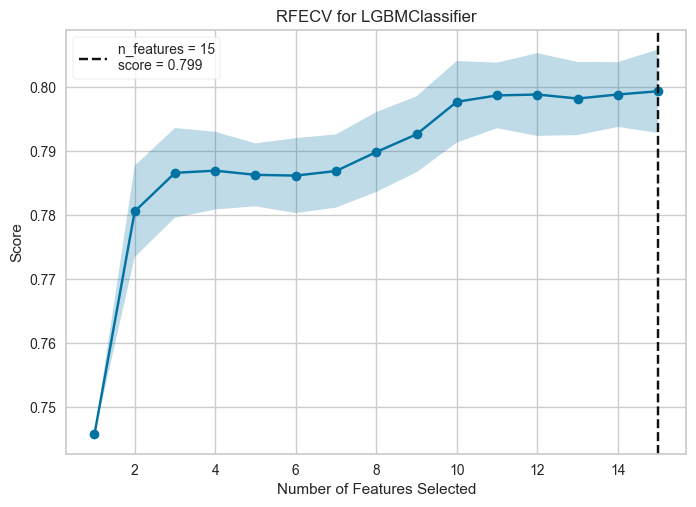

In [42]:
plot_model(best_F1_model, plot = 'rfe')

Learnings from the predictive model:
* The cross-validation score of the lightGBM classifier has the highest 'AUC' and 'F1' metrics among tested models. Therefore, its precision and recall are generally high. 

* One concer is that if the Ultimate requires retrieving retained users most acurately, which relies on the Recall metric. The lightGBM has a fair recall compared with models such as Naive Bayes. If so, Naive Bayes with the highest cross-validation recall will be used.

* The model is trained based on training data (70% of stratified raw data) with 10-fold cross validation and validated with 30% raw data as unseen test data.

## 3.3 Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice)

A: Because the features of `avg_dist` and `weekday_pct` have the highest feature importance score, and these two features contributes most proportion of score during the recursive feature selection, Ultimate might strengthen rider retention by offering promotions on rides with specific distantce range and taken on weekdays.